# 计算不同特征的KS和IV值，比较特征的有效性

In [1]:
from __future__ import division
import math
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

# 1. 计算单个变量的KS和IV值
## 1.1 读数据

KS_IV_example.csv是课上计算KS和IV案例的数据，每一行都表示一个账户

数据包括2个字段：category， score

category = 0/1 表示账户的好/坏

score 表示账户的信用评分


In [2]:
df = pd.read_csv('../data/KS_IV_example.csv')
df.head(3)

,category,score
0,1,99
1,1,99
2,1,99


In [3]:
value_counts = df['category'].value_counts()
good_total = value_counts[0]
bad_total = value_counts[1]
total = good_total + bad_total
print '好账户共有：', good_total
print '坏账户共有：', bad_total

好账户共有： 2121
坏账户共有： 879


## 1.2 按照信用评分score对账户进行分组

- 要求
    - 每组都至少有10%的用户（最后一组例外）
    - 同一score的账户必须分入同一组

In [4]:
# 按照score值重新排序df
df_temp = df.sort_values(by='score')
df_sorted = df_temp.reset_index(level=0, drop=True)

In [5]:
bin_size = int(math.ceil(total * 0.1))

bins = []  # 记录每组最后一个账户
bin_size_list = [] # 记录每组账户个数

num_bins = 0

i = 0
start_index = 0
while i < total:

    end_index = start_index + bin_size - 1
    if end_index >= total - 1:
    # 最后一组，直接分组
        end_index = total - 1
    else:
    # 非最后一组，查看当前组内最后一个账户，是否与下个账户score相同。如果相同，则将下个账户分入当前组
        while end_index + 1 <= total - 1 and df_sorted.ix[end_index]['score'] == df_sorted.ix[end_index + 1]['score']:
            end_index = end_index + 1

    bins.append(end_index)
    bin_size_list.append(end_index-start_index)
    num_bins = num_bins + 1

    start_index = end_index + 1
    i = end_index + 1
    
print '每组最后一个账户的ID分别是: '
print bins

每组最后一个账户的ID分别是: 
[303, 757, 1394, 1768, 2113, 2422, 2732, 2999]


/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


## 1.3 计算KS和IV值

### KS值的计算：计算累积好坏比的最大值

![](../others/KS_example.png)



### IV

![](../others/IV_equation.png)
  


In [6]:
cum_good_ratio = 0
cum_bad_ratio = 0
cum_good_ratio_list = [0]
cum_bad_ratio_list = [0]

IV = 0
KS = 0
start_index = 0

i = 0
while i < num_bins:
    s1 = df_sorted[start_index:(bins[i] + 1)]
    s2 = s1[s1['category'] == 0]
    s3 = s1[s1['category'] == 1]

    good_in_bin = s2.index.size
    bad_in_bin = s3.index.size

    good_ratio_in_bin = good_in_bin / good_total
    bad_ratio_in_bin = bad_in_bin / bad_total
    cum_good_ratio = cum_good_ratio + good_ratio_in_bin
    cum_bad_ratio = cum_bad_ratio + bad_ratio_in_bin
    cum_good_ratio_list.append(cum_good_ratio)
    cum_bad_ratio_list.append(cum_bad_ratio)

    margin = abs(cum_good_ratio - cum_bad_ratio)
    if (margin > KS):
        KS = margin

    iv = (good_ratio_in_bin - bad_ratio_in_bin) * math.log(good_ratio_in_bin / bad_ratio_in_bin)
    IV = IV + iv

    start_index = bins[i] + 1
    i= i + 1

In [7]:
print 'KS: ',round(KS * 100, 1),'%'
print 'IV: ',IV

KS:  27.6 %
IV:  0.515219683831


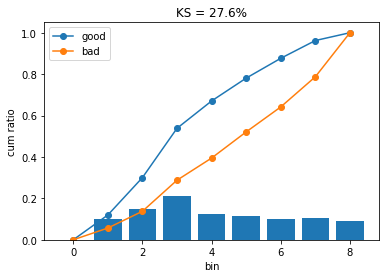

In [8]:
bin_ratio = [0]+[i*1.0/total for i in bin_size_list]
pylab.figure()
pylab.plot(range(len(cum_good_ratio_list)), cum_good_ratio_list, '-o',label='good')
pylab.plot(range(len(cum_bad_ratio_list)), cum_bad_ratio_list, '-o',label='bad')
pylab.legend(loc='upper left')
pylab.bar(range(len(bin_ratio)),bin_ratio)

pylab.ylabel("cum ratio")
pylab.xlabel("bin")
pylab.title('KS = '+str(round(KS * 100, 1))[:4]+"%")
pylab.savefig('../output/KS_example.png')

# 2. 计算数据集中所有变量的KS和IV值

## 需要的函数

In [9]:
def get_KS_IV(category, score):
    """category and score are both lists.
       return the KS and IV value.
    """ 
    cur_df = pd.DataFrame(zip(category,score),columns=['category','feature_score'])
    cur_df = cur_df.sort_values(by='feature_score')
    cur_df = cur_df.reset_index(level=0, drop=True)
    
    value_counts = cur_df['category'].value_counts()
    good_total = value_counts[0]
    bad_total = value_counts[1]
    total = good_total + bad_total
    
    bin_size = int(math.ceil(total * 0.1))
    bins = []# 记录每组最后一个账户

    num_bins = 0
    i = 0
    start_index = 0
    while i < total:

        end_index = start_index + bin_size - 1
        if end_index >= total - 1:
            # 最后一组，直接分组
            end_index = total - 1
        else:
            # 非最后一组，查看当前组内最后一个账户，是否与下个账户score相同。如果相同，则将下个账户分入当前组
            while end_index + 1 <= total - 1 and cur_df.ix[end_index]['feature_score'] == cur_df.ix[end_index + 1]['feature_score']:
                end_index = end_index + 1

        bins.append(end_index)
        num_bins = num_bins + 1

        start_index = end_index + 1
        i = end_index + 1
    
    cum_good_ratio = 0
    cum_bad_ratio = 0

    IV = 0
    KS = 0

    i = 0
    while i < num_bins:
        s1 = cur_df[start_index:(bins[i] + 1)]
        s2 = s1[s1['category'] == 0]
        s3 = s1[s1['category'] == 1]

        good_in_bin = s2.index.size
        bad_in_bin = s3.index.size

        good_ratio_in_bin = good_in_bin / good_total+0.01
        bad_ratio_in_bin = bad_in_bin / bad_total+0.01
        cum_good_ratio = cum_good_ratio + good_ratio_in_bin
        cum_bad_ratio = cum_bad_ratio + bad_ratio_in_bin

        margin = abs(cum_good_ratio - cum_bad_ratio)
        if (margin > KS):
            KS = margin

        iv = (good_ratio_in_bin - bad_ratio_in_bin) * math.log(good_ratio_in_bin / bad_ratio_in_bin)
        IV = IV + iv

        start_index = bins[i] + 1
        i= i + 1
    return KS,IV


In [10]:
def get_KS_IV_features(category,feature_df):
    """categoty is the list to indicate whether the account is good. 
       feature_df is a data frame.
       return the KS and IV value lists.
    """
    KS_IV = []

    for feature in feature_df.columns:
        cur_KS, cur_IV = get_KS_IV(category,feature_df[feature])
        KS_IV.append([cur_KS, cur_IV])
        print '计算完毕: '+feature
    return KS_IV

## 2.1 读数据

- data_clean.csv是1_preprocess处理后的数据
    - 每行都表示一个借款账户
    - loan_status = 0/1， 表示账户的好/坏
- LCDataDictionary.csv是Leng Club数据中的变量含义
- Completeness.csv是各变量缺失比例的数据

In [11]:
df = pd.read_csv('../data/data_clean.csv')
df.head(3)

,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status,issue_d
0,35000,128000.0,6.46,0,685,689,0,46.0,NaN,17,...,91.3,33.3,0,0,220950,49644,26800,71700,0,12
1,16000,70000.0,26.40,0,720,724,0,NaN,NaN,13,...,100.0,60.0,0,0,309638,62407,45900,45838,0,12
2,10000,85000.0,13.07,0,685,689,1,NaN,106.0,14,...,95.7,28.6,1,0,61099,27957,16400,30799,0,12


In [12]:
dict_df = pd.read_csv('../data/LCDataDictionary_clean.csv')
dict_df = dict_df.set_index('feature')
dict_df.head(3)

,Description
feature,
acc_now_delinq,The number of accounts on which the borrower is now delinquent.
acc_open_past_24mths,Number of trades opened in past 24 months.
addr_state,The state provided by the borrower in the loan application


In [13]:
comp_df = pd.read_csv('../output/Completeness.csv')
comp_df = comp_df.set_index('feature')
comp_df.head(3)

,nan_ratio
feature,
loan_amnt,0.0
annual_inc,0.0
dti,0.0


## 2.2 计算各变量的KS和IV值

In [41]:
# features = ['tot_coll_amt','tot_cur_bal','chargeoff_within_12_mths','num_bc_sats']
features = [i for i in df.columns if i not in ['loan_status','issue_d']]
KS_IV = get_KS_IV_features(df.loan_status, df[features])
KS_IV_df = pd.DataFrame(KS_IV, columns = ['KS','IV'],index = features)
KS_IV_df.index.name='feature'

/Users/Aurora/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


计算完毕: loan_amnt
计算完毕: annual_inc
计算完毕: dti
计算完毕: delinq_2yrs
计算完毕: fico_range_low
计算完毕: fico_range_high
计算完毕: inq_last_6mths
计算完毕: mths_since_last_delinq
计算完毕: mths_since_last_record
计算完毕: open_acc
计算完毕: pub_rec
计算完毕: revol_bal
计算完毕: total_acc
计算完毕: acc_now_delinq
计算完毕: tot_coll_amt
计算完毕: tot_cur_bal
计算完毕: open_acc_6m
计算完毕: open_il_6m
计算完毕: open_il_12m
计算完毕: open_il_24m
计算完毕: mths_since_rcnt_il
计算完毕: total_bal_il
计算完毕: il_util
计算完毕: open_rv_12m
计算完毕: open_rv_24m
计算完毕: max_bal_bc
计算完毕: all_util
计算完毕: total_rev_hi_lim
计算完毕: inq_fi
计算完毕: total_cu_tl
计算完毕: inq_last_12m
计算完毕: acc_open_past_24mths
计算完毕: avg_cur_bal
计算完毕: bc_open_to_buy
计算完毕: bc_util
计算完毕: chargeoff_within_12_mths
计算完毕: delinq_amnt
计算完毕: mo_sin_old_il_acct
计算完毕: mo_sin_old_rev_tl_op
计算完毕: mo_sin_rcnt_rev_tl_op
计算完毕: mo_sin_rcnt_tl
计算完毕: mort_acc
计算完毕: mths_since_recent_bc
计算完毕: mths_since_recent_bc_dlq
计算完毕: mths_since_recent_inq
计算完毕: mths_since_recent_revol_delinq
计算完毕: num_accts_ever_120_pd
计算完毕: num_actv_bc_tl
计算完毕: num_a

## 2.3 查看部分变量的结果

In [14]:
# KS_IV_df = pd.read_csv('../output/Effectiveness.csv')
# KS_IV_df = KS_IV_df.set_index('feature')

In [16]:
show_features = ['delinq_2yrs','fico_range_low','fico_range_high','inq_last_6mths','mths_since_last_record']
show_KS_IV_df=KS_IV_df.loc[show_features,]
description_list = []
for feature in show_features:
    description_list.append(dict_df.loc[feature,'Description'])
show_KS_IV_df['feature desctiption'] = description_list
show_KS_IV_df = pd.concat([comp_df.loc[show_features,],show_KS_IV_df],axis=1)
show_KS_IV_df

,nan_ratio,KS,IV,feature desctiption
feature,,,,
delinq_2yrs,0.000000,0.006555,0.000425,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
fico_range_low,0.000000,0.070732,0.072710,The lower boundary range the borrower's FICO at loan origination belongs to.
fico_range_high,0.000000,0.070732,0.072710,The upper boundary range the borrower's FICO at loan origination belongs to.
inq_last_6mths,0.000000,0.114747,0.037908,The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
mths_since_last_record,0.823282,0.120586,0.091712,The number of months since the last public record.


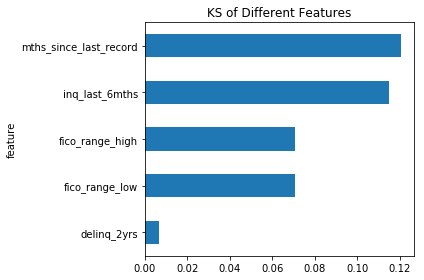

In [17]:
show_KS_IV_df['KS'].plot.barh()
plt.title('KS of Different Features')
plt.tight_layout()
plt.savefig('../output/KS.png')

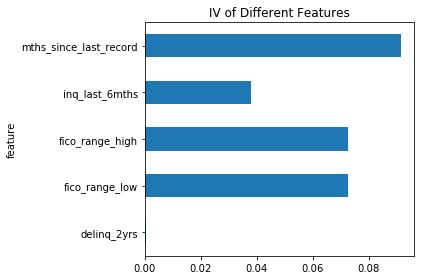

In [18]:
show_KS_IV_df['IV'].plot.barh()
plt.title('IV of Different Features')
plt.tight_layout()
plt.savefig('../output/IV.png')

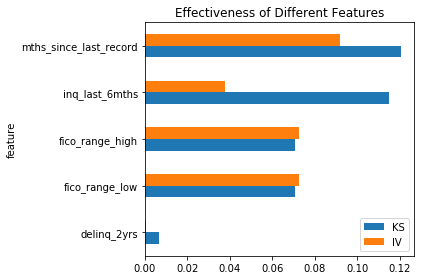

In [19]:
show_KS_IV_df[['KS','IV']].plot.barh(figsize=[6,4])
plt.title('Effectiveness of Different Features')
plt.tight_layout()
plt.savefig('../output/Effectiveness.png')

## 2.4 输出结果到Effectiveness.csv

In [20]:
KS_IV_df.to_csv('../output/Effectiveness.csv')